In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, make_scorer
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import GaussianRandomProjection
from transform_data import get_train_test_ds

random_state = 42
mlp_layers = [128, 64, 16]
dataset_name = 'income'
dataset_dir = 'data/adult.data'

In [19]:
X, X_train, X_test, y, y_train, y_test = get_train_test_ds(dataset_name, dataset_dir, random_state)
X_train.shape, X_test.shape

((26048, 58), (6513, 58))

In [20]:
f1_scorer = make_scorer(f1_score)
mlp_param_grid = {'mlp__alpha': [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
              'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
}

In [21]:
gmm_clusterer = GaussianMixture(n_components=51, covariance_type='full', random_state=random_state)
kmean_clusterer = KMeans(n_clusters=47, random_state=random_state)

In [22]:
class ClusterDM(BaseEstimator):
    def __init__(self, dm, gmm_clusterer, kmean_clusterer):
        self.dm = dm
        self.gmm_clusterer = gmm_clusterer
        self.kmean_clusterer = kmean_clusterer
    
    def _combine_features(self, X):
        dm_X = self.dm.transform(X)
        gmm_X = np.expand_dims(self.gmm_clusterer.predict(X), axis=1)
        kmean_X = np.expand_dims(self.kmean_clusterer.predict(X), axis=1)
        return np.concatenate((dm_X, gmm_X, kmean_X), axis=1)

    def fit(self, X, y=None):
        self.dm.fit(X)
        self.kmean_clusterer.fit(X)
        self.gmm_clusterer.fit(X)
        return self

    def transform(self, X):
        return self._combine_features(X)
        
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)


# PCA

In [23]:
scaler = StandardScaler()
pca = PCA(n_components=40, random_state=random_state)
clusterDM = ClusterDM(pca, gmm_clusterer, kmean_clusterer)
clf = MLPClassifier(
  hidden_layer_sizes=mlp_layers, 
  activation='relu',
  solver='adam',
  learning_rate='adaptive', 
  early_stopping=True, 
  max_iter=128,
  random_state=random_state,
)
pipe = Pipeline([
  ('scaler', scaler), 
  ('cdm', clusterDM),
  ('mlp', clf),
])

In [7]:
grid_search = GridSearchCV(estimator=pipe, param_grid=mlp_param_grid, cv=5, scoring=f1_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

print("Train F1")
y_train_pred = best_model.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(train_f1_score)

print("Test F1")
y_test_pred = best_model.predict(X_test)
test_f1_score = f1_score(y_test, y_test_pred)
print(test_f1_score)

Best parameters: {'mlp__alpha': 0.001, 'mlp__learning_rate_init': 0.01}
Train F1
0.6785046728971963
Test F1
0.665994623655914


In [24]:
%%time

best_params = {'mlp__alpha': 0.001, 'mlp__learning_rate_init': 0.01}

pipe.set_params(**best_params)
pipe.fit(X_train, y_train)
pipe.predict(X_test)

CPU times: user 58.6 s, sys: 1min 46s, total: 2min 45s
Wall time: 17.6 s


array([0, 0, 1, ..., 1, 0, 0])

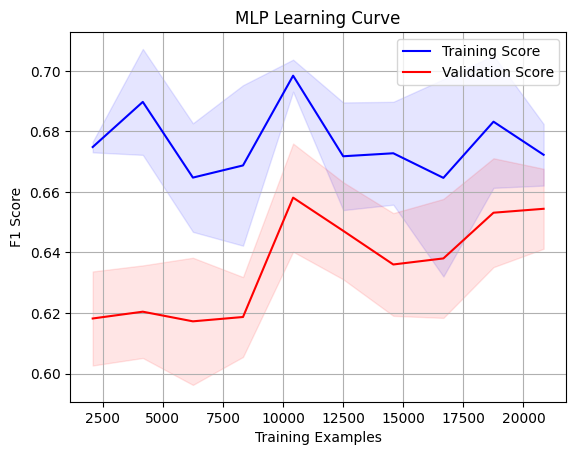

In [9]:
# Define the training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate learning curves
train_sizes_abs, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, train_sizes=train_sizes, cv=5, scoring=f1_scorer)

# Calculate the mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes_abs, train_scores_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes_abs, val_scores_mean, label='Validation Score', color='red')
plt.fill_between(train_sizes_abs, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='red')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('MLP Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# ICA

In [25]:
scaler = StandardScaler()
ica = FastICA(n_components=39, max_iter=500, random_state=random_state)
clusterDM = ClusterDM(ica, gmm_clusterer, kmean_clusterer)
clf = MLPClassifier(
  hidden_layer_sizes=mlp_layers, 
  activation='relu',
  solver='adam',
  learning_rate='adaptive', 
  early_stopping=True, 
  max_iter=128,
  random_state=random_state,
)
pipe = Pipeline([
  ('scaler', scaler), 
  ('cdm', clusterDM),
  ('mlp', clf),
])

In [11]:
grid_search = GridSearchCV(estimator=pipe, param_grid=mlp_param_grid, cv=5, scoring=f1_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

print("Train F1")
y_train_pred = best_model.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(train_f1_score)

print("Test F1")
y_test_pred = best_model.predict(X_test)
test_f1_score = f1_score(y_test, y_test_pred)
print(test_f1_score)

Best parameters: {'mlp__alpha': 0.001, 'mlp__learning_rate_init': 0.01}
Train F1
0.6855184233076264
Test F1
0.6675703151474076


In [26]:
%%time

best_params = {'mlp__alpha': 0.001, 'mlp__learning_rate_init': 0.01}

pipe.set_params(**best_params)
pipe.fit(X_train, y_train)
pipe.predict(X_test)

CPU times: user 59.5 s, sys: 2min 2s, total: 3min 2s
Wall time: 19 s


array([0, 0, 1, ..., 1, 0, 0])

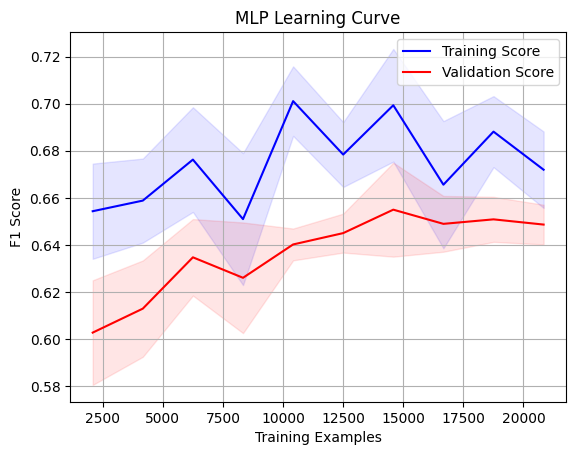

In [13]:
# Define the training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate learning curves
train_sizes_abs, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, train_sizes=train_sizes, cv=5, scoring=f1_scorer)

# Calculate the mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes_abs, train_scores_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes_abs, val_scores_mean, label='Validation Score', color='red')
plt.fill_between(train_sizes_abs, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='red')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('MLP Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# Random projection

In [27]:
scaler = StandardScaler()
rca = GaussianRandomProjection(n_components=33, random_state=random_state)
clusterDM = ClusterDM(rca, gmm_clusterer, kmean_clusterer)
clf = MLPClassifier(
  hidden_layer_sizes=mlp_layers, 
  activation='relu',
  solver='adam',
  learning_rate='adaptive', 
  early_stopping=True, 
  max_iter=128,
  random_state=random_state,
)
pipe = Pipeline([
  ('scaler', scaler), 
  ('cdm', clusterDM),
  ('mlp', clf),
])

In [15]:
grid_search = GridSearchCV(estimator=pipe, param_grid=mlp_param_grid, cv=5, scoring=f1_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

print("Train F1")
y_train_pred = best_model.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(train_f1_score)

print("Test F1")
y_test_pred = best_model.predict(X_test)
test_f1_score = f1_score(y_test, y_test_pred)
print(test_f1_score)

Best parameters: {'mlp__alpha': 0.01, 'mlp__learning_rate_init': 0.01}
Train F1
0.6683588621444201
Test F1
0.6641221374045801


In [28]:
%%time

best_params = {'mlp__alpha': 0.01, 'mlp__learning_rate_init': 0.01}

pipe.set_params(**best_params)
pipe.fit(X_train, y_train)
pipe.predict(X_test)

CPU times: user 56.2 s, sys: 1min 49s, total: 2min 45s
Wall time: 17.8 s


array([0, 0, 1, ..., 1, 0, 0])

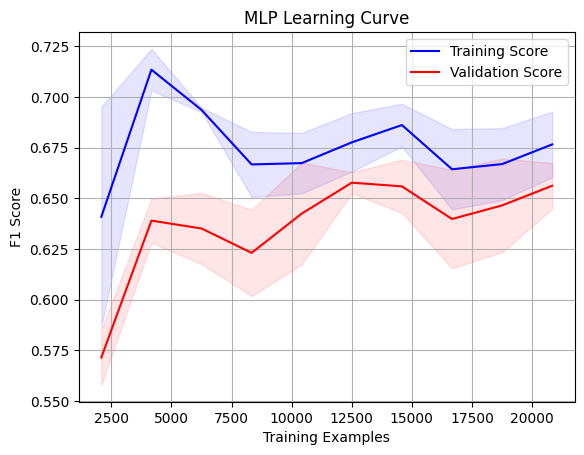

In [17]:
# Define the training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate learning curves
train_sizes_abs, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, train_sizes=train_sizes, cv=5, scoring=f1_scorer)

# Calculate the mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes_abs, train_scores_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes_abs, val_scores_mean, label='Validation Score', color='red')
plt.fill_between(train_sizes_abs, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='red')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('MLP Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# t-SNE

In [12]:
class CustomTSNE(BaseEstimator):
    def __init__(self, **kwargs):
        self.estimator = TSNE(**kwargs)

    def fit(self, X, y=None):
        self.estimator.fit(X)
        return self

    def transform(self, X):
        return self.estimator.fit_transform(X)
        
    def fit_transform(self, X, y):
        return self.estimator.fit_transform(X)

In [13]:
scaler = StandardScaler()
tsne = CustomTSNE(n_components=3, n_jobs=-1, random_state=random_state)
clusterDM = ClusterDM(tsne, gmm_clusterer, kmean_clusterer)
clf = MLPClassifier(
  hidden_layer_sizes=mlp_layers, 
  activation='relu',
  solver='adam',
  learning_rate='adaptive', 
  early_stopping=True, 
  max_iter=128,
  random_state=random_state,
)
pipe = Pipeline([
  ('scaler', scaler), 
  ('cdm', clusterDM),
  ('mlp', clf),
])

In [ ]:
grid_search = GridSearchCV(estimator=pipe, param_grid=mlp_param_grid, cv=5, scoring=f1_scorer, n_jobs=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

print("Train F1")
y_train_pred = best_model.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(train_f1_score)

print("Test F1")
y_test_pred = best_model.predict(X_test)
test_f1_score = f1_score(y_test, y_test_pred)
print(test_f1_score)

Best parameters: {'mlp__alpha': 0.1, 'mlp__learning_rate_init': 0.001}
Train F1
0.5846526516134614
Test F1
0.4340679865521106


In [14]:
%%time

best_params = {'mlp__alpha': 0.1, 'mlp__learning_rate_init': 0.001}

pipe.set_params(**best_params)
pipe.fit(X_train, y_train)
pipe.predict(X_test)

CPU times: user 29min 3s, sys: 2min 21s, total: 31min 24s
Wall time: 5min 47s


array([1, 0, 1, ..., 0, 0, 0])

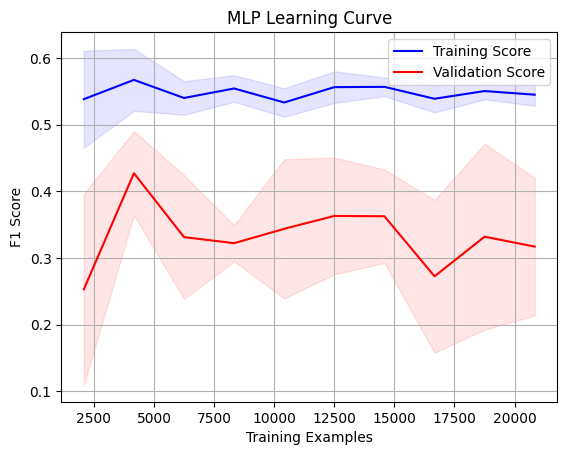

In [9]:
# Define the training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate learning curves
train_sizes_abs, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, train_sizes=train_sizes, cv=5, scoring=f1_scorer)

# Calculate the mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes_abs, train_scores_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes_abs, val_scores_mean, label='Validation Score', color='red')
plt.fill_between(train_sizes_abs, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='red')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('MLP Learning Curve')
plt.legend()
plt.grid(True)
plt.show()